# Trabajo 1
Procesamiento de Lenguaje Natural
2024-02

## Integrantes
- Stefany Cantero Cardenas
- Juan Manuel Vera Echaverri
- Sebastian Arango Urrea


In [ ]:
# b4s
!pip install beautifulsoup4
# scrapy
!pip install scrapy
# nltk
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.5/254.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 6.1 MB/s eta 0:00:00


In [ ]:
import os

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer
from nltk.util import ngrams

import scrapy # type: ignore

from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
#from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


from collections import Counter
import xml.etree.ElementTree as ET
import string
import re

In [ ]:
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Creación del Corpus - Web Scrapping

## Corpus Fuente 1

La extracción de texto se realizó haciendo uso de las librerías BeautifulSoup, Playwright y Scrapy. A medida que se iban obteniendo los comentarios, se realizó el análisis de sentimientos para su posterior distribución a las carpetas 'pos' y 'neg'.

### Scrapy

Para obtener comentarios relacionados con política se hizo uso del foro El Otro Lado donde se abren espacios de discusión sobre distintos temas. En este caso, el elegido fue la invasión y el conflicto bélico de Rusia y Ucrania.

In [ ]:
!scrapy startproject textscraper
%cd textscraper/textscraper/spiders
!scrapy genspider TextSpider https://www.elotrolado.net/hilo_invasion-rusa-de-ucrania_2446022

New Scrapy project 'textscraper', using template directory '/usr/local/lib/python3.10/dist-packages/scrapy/templates/project', created in:
    /content/textscraper

You can start your first spider with:
    cd textscraper
    scrapy genspider example example.com
/content/textscraper/textscraper/spiders
Created spider 'TextSpider' using template 'basic' in module:
  textscraper.spiders.TextSpider


#### Codigo TextSpider

In [ ]:
class ScraperSpider(scrapy.Spider):
    name = "Scraper"
    allowed_domains = ["www.elotrolado.net"]
    start_urls = ["https://www.elotrolado.net/hilo_invasion-rusa-de-ucrania_2446022"]

    def preprocess_comments(self, comments):
      clean_comments = []

      for comment in comments:
        # Normalizacion a minus
        comment = comment.lower()
        # Eliminacion de tildes
        comment = comment.replace('á', 'a')
        comment = comment.replace('é', 'e')
        comment = comment.replace('í', 'i')
        comment = comment.replace('ó', 'o')
        comment = comment.replace('ú', 'u')
        # Eliminacion de numeros
        comment = ''.join([i for i in comment if not i.isdigit()])
        # Eliminacion de caracteres especiales
        comment = ''.join([i for i in comment if i.isalnum() or i.isspace()])
        # Eliminacion de enlaces
        comment = ' '.join([i for i in comment.split() if not i.startswith('http')])
        # ELiminacion de \n
        comment = comment.replace('\n', ' ')
        # Eliminacion de signos asociados a HTML
        comment = comment.replace('&lt;', '<')
        comment = comment.replace('&gt;', '>')
        comment = comment.replace('&quot;', '"')
        comment = comment.replace('&amp;', '&')
        # Eliminacion de signos de puntuacion y emoticones
        comment = comment.replace('!', '')
        comment = comment.replace('?', '')
        comment = comment.replace(':', '')
        comment = comment.replace(';', '')
        comment = comment.replace(',', '')
        comment = comment.replace('.', '')

        clean_comments.append(comment)
      return clean_comments

    def analyze_sentiment(self, texts):
        for t in texts:
            blob = TextBlob(t)
            yield t, blob.sentiment.polarity

    def distribute_sentiment(self, pos_comments, neg_comments):
        # Crear carpetas para comentarios positivos y negativos
        pos_folder = '/content/drive/Shareddrives/PLN/Trabajo1/Textos/positive'
        os.makedirs(pos_folder, exist_ok=True)

        neg_folder = '/content/drive/Shareddrives/PLN/Trabajo1/Textos/negative'
        os.makedirs(neg_folder, exist_ok=True)

        # Guardar comentarios positivos y negativos en la carpeta correspondiente
        for i, text in enumerate(pos_comments):
            with open(os.path.join(pos_folder, f"pos_pol_{i + 1}.txt"), 'w', encoding='utf-8') as f:
                f.write(text)

        for i, text in enumerate(neg_comments):
            with open(os.path.join(neg_folder, f"neg_pol_{i + 1}.txt"), 'w', encoding='utf-8') as f:
                f.write(text)

    def parse(self, response):
        pos_comments = []
        neg_comments = []

        # Extraer comentarios junto con todo su contenido
        comments = response.css("div.col-xs-24.message").getall()
        comments_cleaned = []

        for comment in comments:
            # Crear un selector para procesar cada comentario
            selector = scrapy.Selector(text=comment)

            # Extraer texto del contenido restante
            text_parts = selector.css("*::text").getall()
            full_comment = " ".join([part.strip() for part in text_parts if part.strip()])
            comments_cleaned.append(full_comment)

        comments_cleaned = self.preprocess_comments(comments_cleaned)
        # Analizar sentimientos y clasificar comentarios
        sentiment = self.analyze_sentiment(comments_cleaned)
        for text, polarity in sentiment:
            if polarity > 0 and len(pos_comments) < 25:
                pos_comments.append(text)
            elif polarity < 0 and len(neg_comments) < 25:
                neg_comments.append(text)
            else:
                pass

        self.distribute_sentiment(pos_comments, neg_comments)

        pagination_links = response.css("div.pages a[href*='hilo_invasion-rusa-de-ucrania_2446022_s']::attr(href)").getall()
        for link in pagination_links:
            yield response.follow(link, self.parse)

In [ ]:
!scrapy runspider TextSpider.py

2024-12-18 03:04:18 [scrapy.utils.log] INFO: Scrapy 2.12.0 started (bot: textscraper)
2024-12-18 03:04:18 [scrapy.utils.log] INFO: Versions: lxml 5.3.0.0, libxml2 2.12.9, cssselect 1.2.0, parsel 1.9.1, w3lib 2.2.1, Twisted 24.11.0, Python 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0], pyOpenSSL 24.2.1 (OpenSSL 3.3.2 3 Sep 2024), cryptography 43.0.3, Platform Linux-6.1.85+-x86_64-with-glibc2.35
2024-12-18 03:04:18 [scrapy.addons] INFO: Enabled addons:
[]
2024-12-18 03:04:18 [asyncio] DEBUG: Using selector: EpollSelector
2024-12-18 03:04:18 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.asyncioreactor.AsyncioSelectorReactor
2024-12-18 03:04:18 [scrapy.utils.log] DEBUG: Using asyncio event loop: asyncio.unix_events._UnixSelectorEventLoop
2024-12-18 03:04:18 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.asyncioreactor.AsyncioSelectorReactor
2024-12-18 03:04:18 [scrapy.utils.log] DEBUG: Using asyncio event loop: asyncio.unix_events._UnixSelectorEventLoop
2024-12-

### BeautifulSoup - Playwright

In [ ]:
%cd /content/drive/Shareddrives/PLN/Trabajo1/Codigos

/content/drive/Shareddrives/PLN/Trabajo1/Codigos


#### Comentarios de economía

Para los comentarios de economía se extrajeron los datos del foro Rankia, categoría Bolsa.

In [ ]:
%run extraccion_datos_eco.ipynb

Playwright Host validation warning: 
╔══════════════════════════════════════════════════════╗
║ Host system is missing dependencies to run browsers. ║
║ Missing libraries:                                   ║
║     libwoff2dec.so.1.0.2                             ║
║     libgstgl-1.0.so.0                                ║
║     libgstcodecparsers-1.0.so.0                      ║
║     libavif.so.13                                    ║
║     libharfbuzz-icu.so.0                             ║
║     libenchant-2.so.2                                ║
║     libsecret-1.so.0                                 ║
║     libhyphen.so.0                                   ║
║     libmanette-0.2.so.0                              ║
╚══════════════════════════════════════════════════════╝
    at validateDependenciesLinux (/usr/local/lib/python3.10/dist-packages/playwright/driver/package/lib/server/registry/dependencies.js:216:9)
    at process.processTicksAndRejections (node:internal/process/task_queues:105

RuntimeError: Cannot run the event loop while another loop is running

RuntimeError: Cannot run the event loop while another loop is running

#### Comentarios culturales

En el caso de los comentarios culturales, igualmente se eligieron discusiones del foro El Otro Lado.

In [ ]:
%run textractor.ipynb

/usr/lib/python3.10/sre_parse.py:186: RuntimeWarning: coroutine 'InteractiveShell.run_cell_async' was never awaited
  i = min(i, l)


Positivo: 156
Negativos:30
Neutros: 366
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Corpus Fuente 2

In [ ]:
%run TASS_extraction.ipynb

### Métricas

In [ ]:
%cd /content/drive/Shareddrives/PLN/Trabajo1/Textos

/content/drive/Shareddrives/PLN/Trabajo1/Textos


In [ ]:
positive_folder = '/content/drive/Shareddrives/PLN/Trabajo1/Textos/positive'
negative_folder = '/content/drive/Shareddrives/PLN/Trabajo1/Textos/negative'
print(len(os.listdir(positive_folder)))
print(len(os.listdir(negative_folder)))

3684
3684


In [ ]:
raw_data = []
def text_to_dataframe(folder, sentiment):
  for filename in os.listdir(folder):
      if filename.endswith('.txt'):
          with open(os.path.join(folder, filename), 'r', encoding='utf-8') as f:
              text = f.read()
              raw_data.append((text, sentiment))
  return raw_data

In [ ]:
text_to_dataframe(positive_folder, "P")
text_to_dataframe(negative_folder, "N")
df = pd.DataFrame(raw_data, columns=['text', 'sentiment'])

In [ ]:
df

,text,sentiment
0,@mjguemes un beso de parte de tu poeta preferido,P
1,Buenos días ;-)),P
2,Empezamos ya!!!! No somos telesucesos. Si quie...,P
3,@javierarenas_pp #PROPONE: Plan de ahorro del ...,P
4,El @PPopular mantiene siempre una actitud cons...,P
...,...,...
7363,Quién es la que canta que su corazón la aprisi...,N
7364,Correctivo de Trabajo a la denuncia del PSOE: ...,N
7365,Las cámaras d @13tv_AlDia están preguntando: ¿...,N
7366,Así defienden a los trabajadores los sindicato...,N


In [ ]:
data = []

for _, texto in df.iterrows():
    #tokenización del texto
    raw_text = texto['text']
    tokens = nltk.word_tokenize(raw_text)
    vocab = set(tokens)
    frases = nltk.sent_tokenize(raw_text)

    # Cálculo de métricas
    num_palabras = len(tokens)
    vocab_size = len(vocab)
    riqueza_lexica = vocab_size / num_palabras
    frecuencia = FreqDist(tokens)
    longitud_palabras = [len(token) for token in tokens]
    longitud_frases = [len(frase) for frase in frases]

    data.append({
        'Texto': raw_text,
        'Media de Longitud de Palabras': np.mean(longitud_palabras),
        'Desviación Estándar de Longitud de Palabras': np.std(longitud_palabras),
        'Min Longitud de Palabras': np.min(longitud_palabras),
        'Max Longitud de Palabras': np.max(longitud_palabras),
        'Cuartiles de Longitud de Palabras': np.percentile(longitud_palabras, [25, 50, 75]).tolist(),
        'Número de Palabras': num_palabras,
    })


In [ ]:
metrics_df = pd.DataFrame(data)
metrics_df

,Texto,Media de Longitud de Palabras,Desviación Estándar de Longitud de Palabras,Min Longitud de Palabras,Max Longitud de Palabras,Cuartiles de Longitud de Palabras,Número de Palabras
0,@mjguemes un beso de parte de tu poeta preferido,4.000000,2.607681,1,9,"[2.0, 3.0, 5.0]",10
1,Buenos días ;-)),2.333333,1.972027,1,6,"[1.0, 1.0, 3.25]",6
2,Empezamos ya!!!! No somos telesucesos. Si quie...,4.545455,4.153063,1,15,"[1.0, 2.0, 7.5]",22
3,@javierarenas_pp #PROPONE: Plan de ahorro del ...,4.680000,3.663004,1,15,"[1.0, 4.0, 7.0]",25
4,El @PPopular mantiene siempre una actitud cons...,5.227273,3.436857,1,12,"[2.0, 4.5, 7.75]",22
...,...,...,...,...,...,...,...
7363,Quién es la que canta que su corazón la aprisi...,3.846154,2.281907,1,9,"[2.0, 3.0, 5.0]",13
7364,Correctivo de Trabajo a la denuncia del PSOE: ...,4.259259,3.667602,1,15,"[1.5, 3.0, 6.5]",27
7365,Las cámaras d @13tv_AlDia están preguntando: ¿...,4.625000,3.772847,1,12,"[1.0, 3.0, 7.25]",24
7366,Así defienden a los trabajadores los sindicato...,5.409091,3.961853,1,15,"[2.0, 4.5, 8.0]",22


# 2. Preprocesamiento de datos

In [ ]:
def preprocesar_comentarios(comments):
  comments_preprocesados = []

  for comment in comments:
    # Normalizacion a minus
    comment = comment.lower()
    # Eliminacion de tildes
    comment = comment.replace('á', 'a')
    comment = comment.replace('é', 'e')
    comment = comment.replace('í', 'i')
    comment = comment.replace('ó', 'o')
    comment = comment.replace('ú', 'u')
    # Eliminacion de numeros
    comment = ''.join([i for i in comment if not i.isdigit()])
    # Eliminacion de caracteres especiales
    comment = ''.join([i for i in comment if i.isalnum() or i.isspace()])
    # Eliminacion de enlaces
    comment = ' '.join([i for i in comment.split() if not i.startswith('http')])
    comment = ' '.join([i for i in comment.split() if not i.endswith('com')])
    comment = ' '.join([i for i in comment.split() if not i.endswith('net')])
    comment = ' '.join([i for i in comment.split() if not i.endswith('org')])
    # ELiminacion de \n
    comment = comment.replace('\n', ' ')

    comments_preprocesados.append(comment)

  return comments_preprocesados


In [ ]:
df_limpio = pd.DataFrame({"texto":preprocesar_comentarios(df["text"])})
y = df["sentiment"]
df_limpio

,texto
0,mjguemes un beso de parte de tu poeta preferido
1,buenos dias
2,empezamos ya no somos telesucesos si quiere in...
3,javierarenaspp propone plan de ahorro del gast...
4,el ppopular mantiene siempre una actitud const...
...,...
7363,quien es la que canta que su corazon la aprisi...
7364,correctivo de trabajo a la denuncia del psoe r...
7365,las camaras d tvaldia estan preguntando aprueb...
7366,asi defienden a los trabajadores los sindicato...


In [ ]:
y

,sentiment
0,P
1,P
2,P
3,P
4,P
...,...
7363,N
7364,N
7365,N
7366,N


In [ ]:
df_limpio.to_csv("df_limpio_ultimate.csv")
y.to_csv("y_ultimate.csv")

In [ ]:
df_texts = df_limpio.copy()

# 3. EXTRACCIÓN DE CARACTERISTICAS
A partir del corpus obtenido en el paso anterior, se procederá a crear las
características, haciendo uso del modelo de bolsa de palabras (bag of words-
BoW).

a. Para esto se realizará inicialmente el proceso de tokenización. Esta bolsa de palabras en nuestro caso contendrá unigramas, es decir tokens
independientes, y bigramas formados por la concatenación de dos tokens
preservando el orden original que estos tenían dentro del texto del que proceden.

b. Luego se llevará a cabo las tareas de reducción de stopwords. Para ello se
realizarán dos tipos de procesos de stopwords:
- Eliminar los tokens (unigramas y bigramas) asociados a la lista de
palabras de palabras vacías (stopword) predefinidas por las librerías
vistas en clase para español se eliminan de la bolsa de palabras. En este
grupo se incluyen pronombres, artículos, conjunciones, preposiciones,
etc.
- Eliminar los tokens (unigramas y bigramas) mediante la eliminación por
frecuencia. Para este caso términos que aparecen menos de 3 se
eliminan de la bolsa de palabras.

c. Luego se realizará el proceso de normalización mediante stemming para las
palabras de la bolsa de palabras (unigramas y bigramas) resultante del anterior
proceso.

En este punto como se verá más adelante, en las pruebas se medirá la eficacia
de aplicar ambos procesos (stopwords y stemming) en el proceso de análisis de
sentimiento.

In [ ]:
def get_unigrams(text):
    # Tokenización
    tokens = nltk.word_tokenize(str(text))
    unigrams = list(ngrams(tokens, 1))

    return unigrams

def get_unibigrams(text):
    # Tokenización
    tokens = nltk.word_tokenize(str(text))

    # Unigramas y bigramas
    unigrams = list(ngrams(tokens, 1))
    bigrams = list(ngrams(tokens, 2))

    # Combinar unigramas y bigramas
    all_ngrams = [ ' '.join(gram) for gram in unigrams] + [' '.join(gram) for gram in bigrams]

    return all_ngrams

In [ ]:
# Generación de unigramas y bigramas
def get_bag_of_words(df):
    corpus = []
    for index, row in df.iterrows():
      corpus.extend(row['tokens'])
    return corpus

In [ ]:
df_texts["tokens"] = df_texts["texto"].apply(get_unibigrams)

df_texts

,texto,tokens
0,mjguemes un beso de parte de tu poeta preferido,"[mjguemes, un, beso, de, parte, de, tu, poeta,..."
1,buenos dias,"[buenos, dias, buenos dias]"
2,empezamos ya no somos telesucesos si quiere in...,"[empezamos, ya, no, somos, telesucesos, si, qu..."
3,javierarenaspp propone plan de ahorro del gast...,"[javierarenaspp, propone, plan, de, ahorro, de..."
4,el ppopular mantiene siempre una actitud const...,"[el, ppopular, mantiene, siempre, una, actitud..."
...,...,...
7363,quien es la que canta que su corazon la aprisi...,"[quien, es, la, que, canta, que, su, corazon, ..."
7364,correctivo de trabajo a la denuncia del psoe r...,"[correctivo, de, trabajo, a, la, denuncia, del..."
7365,las camaras d tvaldia estan preguntando aprueb...,"[las, camaras, d, tvaldia, estan, preguntando,..."
7366,asi defienden a los trabajadores los sindicato...,"[asi, defienden, a, los, trabajadores, los, si..."


In [ ]:
bow = pd.concat([df_texts['tokens'], y], axis=1)
bow

,tokens,sentiment
0,"[mjguemes, un, beso, de, parte, de, tu, poeta,...",P
1,"[buenos, dias, buenos dias]",P
2,"[empezamos, ya, no, somos, telesucesos, si, qu...",P
3,"[javierarenaspp, propone, plan, de, ahorro, de...",P
4,"[el, ppopular, mantiene, siempre, una, actitud...",P
...,...,...
7363,"[quien, es, la, que, canta, que, su, corazon, ...",N
7364,"[correctivo, de, trabajo, a, la, denuncia, del...",N
7365,"[las, camaras, d, tvaldia, estan, preguntando,...",N
7366,"[asi, defienden, a, los, trabajadores, los, si...",N


In [ ]:
len(bow)

7368

In [ ]:
def remove_stopwords_from_df(df, min_freq=3):

    # Lista de stopwords en español
    stop_words = set(stopwords.words('spanish'))

    # Combinar todas las listas de tokens para calcular las frecuencias totales
    all_tokens = [token for tokens in df['tokens'] for token in tokens]
    token_frequencies = Counter(all_tokens)

    # Filtrar tokens que no sean stopwords y que cumplan con la frecuencia mínima
    def filtrar_tokens(tokens):
        return [
            token for token in tokens
            if token not in stop_words and token_frequencies[token] >= min_freq
        ]

    # Aplicar el filtrado a cada fila de la columna "tokens"
    df['tokens'] = df['tokens'].apply(filtrar_tokens)

    return df


In [ ]:
bow_stopword = remove_stopwords_from_df(bow)
bow_stopword

,tokens,sentiment
0,"[mjguemes, beso, parte, poeta, un beso, parte ...",P
1,"[buenos, dias, buenos dias]",P
2,"[empezamos, si, quiere, informacion, criterio,...",P
3,"[javierarenaspp, propone, plan, ahorro, gasto,...",P
4,"[ppopular, mantiene, siempre, actitud, impulso...",P
...,...,...
7363,"[canta, corazon, querer, quien es, es la, la q...",N
7364,"[trabajo, denuncia, psoe, coste, cartas, millo...",N
7365,"[camaras, d, tvaldia, estan, preguntando, apru...",N
7366,"[asi, defienden, trabajadores, sindicatos, reb...",N


In [ ]:
def normalize_words_in_df(df):
    stemmer = SnowballStemmer('spanish')

    # Aplicar stemming a cada token en la columna 'tokens'
    df['tokens'] = df['tokens'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])

    return df

In [ ]:
bow_stemmed = normalize_words_in_df(bow)
print(len(bow_stemmed))
bow_stemmed[:20]

7368


,tokens,sentiment
0,"[mjguem, bes, part, poet, un bes, parte d, de tu]",P
1,"[buen, dias, buenos di]",P
2,"[empez, si, quier, inform, criteri, telediario...",P
3,"[javierarenaspp, propon, plan, ahorr, gast, to...",P
4,"[ppopul, mantien, siempr, actitud, impuls, tod...",P
5,"[hoy, fiest, constitucion, congres, diput, deb...",P
6,"[conozc, perfect, rt, alejandrosanz, onda, ale...",P
7,"[music, magic, romant, maravill, puest, escen,...",P
8,"[zapater, leccion, europ, españ, experient, go...",P
9,"[garzon, consegu, parezc, acus, juez, impresio...",P


In [ ]:
bow_stopword_stemmed = normalize_words_in_df(bow_stopword)
print(len(bow_stopword_stemmed))
bow_stopword_stemmed[:20]

7368


,tokens,sentiment
0,"[mjguem, bes, part, poet, un bes, parte d, de tu]",P
1,"[buen, dias, buenos di]",P
2,"[empez, si, qui, inform, criteri, telediarioin...",P
3,"[javierarenaspp, propon, plan, ahorr, gast, to...",P
4,"[ppopul, manti, siempr, actitud, impuls, tod, ...",P
5,"[hoy, fiest, constitucion, congr, diput, deb, ...",P
6,"[conozc, perfect, rt, alejandrosanz, onda, ale...",P
7,"[music, magic, romant, maravill, puest, escen,...",P
8,"[zapat, leccion, europ, españ, experient, gobi...",P
9,"[garzon, consegu, parezc, acus, juez, impresio...",P


In [ ]:
bows = [bow, bow_stopword, bow_stemmed, bow_stopword_stemmed]

## 4. Ponderación de características

Las características extraídas en el paso anterior pueden ser consideradas de
igual importancia u otorgarles distintos pesos en función de algún tipo de criterio.

Estos pesos determinan la relevancia de cada característica dentro del texto del
que pertenecen y por lo tanto influyen en el momento de clasificar los textos en
las polaridades de sentimiento por parte de los algoritmos de aprendizaje.

Para tal fin se hará uso de las dos ponderaciones vistas en clase para las evaluaciones como se verá más adelante.

- **Frecuencia absoluta (Term Ocurrences o TO)**: aquí cada característica
tiene un peso igual al número de veces que aparece en un documento
dado del corpus conformado.

- **Esquema TF-IDF (Term Frecuency-Inverse Document Frecuency)**: Esta
ponderación otorga una mayor importancia a aquellas características que
aparecen un mayor número de veces en el corpus, pero en pocos
documentos del mismo.

In [ ]:
def vectorizar(df):

  # Convertir tokens a texto concatenado
  df['processed_text'] = df['tokens'].apply(lambda x: ' '.join(x))
  # Inicializar CountVectorizer
  count_vec = CountVectorizer()

  # Generar la matriz de características
  X_count = count_vec.fit_transform(df['processed_text'])

  # Inicializar TfidfVectorizer
  tfidf_vec = TfidfVectorizer()

  # Generar la matriz de características
  X_tfidf = tfidf_vec.fit_transform(df['processed_text'])

  return X_count, X_tfidf

## 5. Técnicas de aprendizaje

Se compararán tres algoritmos
1. regresión logística
2. árboles de decisión
3. k-vecinos más cercanos
Para realizar la tarea de análisis de sentimiento.

Para su comparación se fabricarán varios ambientes acordes a los pasos anteriormente descritos como se describe a continuación.
- Reducción y Normalización del corpus: Se probarán 4 combinaciones
distintas de reducción del espacio vectorial: sin ninguna técnica, solo
aplicando la eliminación de stopwords, solo mediante stemming y con
ambas a la vez.
- Ponderación de las características: existirán modelos con cada una de las
2 técnicas relacionadas: Frecuencia absoluta (TO) y TF-IDF.
Para cada técnica y caso de estudio se construirá la entrada a la técnica que
consistirá en la matriz de características y sus etiquetas respectivas de cada
documento siendo
  - 1 polarización positiva
  - 0 polarización negativa.

Las métricas utilizadas para cada uno de los casos serán:
  - Accuracy
  - Precisión,
  - Recall
  - F1-score.

Para obtener una mayor fiabilidad en los resultados y evitar efectos no deseados
de sobreajuste (overfitting), se probarán todos los modelos mediante un
esquema de validación cruzada de k iteraciones en donde k es igual a 10. La
medida de referencia será el valor F1 ponderado. Se usará para los datos de
entrenamiento el 80% de los mensajes y el 20% será para Test del corpus
originalmente obtenido en el punto 1.

Para mostrar los resultados, hacer uso de la siguiente tabla que detalla cada una de las configuraciones de los modelos.

In [ ]:
# Tabla base
table = {
    "Ponderación": ["TO", "TO", "TO", "TO", "TF-IDF", "TF-IDF", "TF-IDF", "TF-IDF"],
    "STOPWORDS": [False, True, False, True, False, True, False, True],
    "STEMMING": [False, False, True, True, False, False, True, True],
    "Accuracy_reg": [None, None, None, None, None, None, None, None],
    "Precisión_reg": [None, None, None, None, None, None, None, None],
    "Recall_reg": [None, None, None, None, None, None, None, None],
    "F1-Score_reg": [None, None, None, None, None, None, None, None],
    "Accuracy_trees": [None, None, None, None, None, None, None, None],
    "Precisión_trees": [None, None, None, None, None, None, None, None],
    "Recall_trees": [None, None, None, None, None, None, None, None],
    "F1-Score_trees": [None, None, None, None, None, None, None, None],
    "Accuracy_knn": [None, None, None, None, None, None, None, None],
    "Precisión_knn": [None, None, None, None, None, None, None, None],
    "Recall_knn": [None, None, None, None, None, None, None, None],
    "F1-Score_knn": [None, None, None, None, None, None, None, None]
}

table = pd.DataFrame(table)

In [ ]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

def fill_table(df, index):
    index_temp = index
    corpus_procesado = df.copy()
    corpus_procesado['sentiment'] = corpus_procesado['sentiment'].replace({'P': 1, 'N': 0})

    # Vectorizar el corpus
    X_freq, X_tfidf = vectorizar(corpus_procesado)
    y = corpus_procesado['sentiment']

    # Definir los modelos
    modelos = {
        "reg": LogisticRegression(),
        "trees": DecisionTreeClassifier(),
        "knn": KNeighborsClassifier()
    }

    # Configuración de Cross-Validation
    kf = KFold(n_splits=10, shuffle=True, random_state=43)

    # Función para correr cross-validation
    def cross_val_metrics(model, X, y):
        scoring = ['accuracy', 'precision', 'recall', 'f1']
        scores = cross_validate(model, X, y, cv=kf, scoring=scoring)
        return {
            'accuracy': scores['test_accuracy'].mean(),
            'precision': scores['test_precision'].mean(),
            'recall': scores['test_recall'].mean(),
            'f1': scores['test_f1'].mean()
        }

    # Evaluar modelos con X_freq
    for name, modelo in modelos.items():
        metrics = cross_val_metrics(modelo, X_freq, y)
        table.loc[index, f"Precisión_{name}"] = metrics['precision']
        table.loc[index, f"Recall_{name}"] = metrics['recall']
        table.loc[index, f"F1-Score_{name}"] = metrics['f1']
        table.loc[index, f"Accuracy_{name}"] = metrics['accuracy']

    # Evaluar modelos con X_tfidf
    index_temp += 4
    for name, modelo in modelos.items():
        metrics = cross_val_metrics(modelo, X_tfidf, y)
        table.loc[index_temp, f"Precisión_{name}"] = metrics['precision']
        table.loc[index_temp, f"Recall_{name}"] = metrics['recall']
        table.loc[index_temp, f"F1-Score_{name}"] = metrics['f1']
        table.loc[index_temp, f"Accuracy_{name}"] = metrics['accuracy']


In [ ]:
index = 0
for bow in bows:

  fill_table(bow, index)
  index += 1

<ipython-input-47-c60ca983c13e>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corpus_procesado['sentiment'] = corpus_procesado['sentiment'].replace({'P': 1, 'N': 0})
<ipython-input-47-c60ca983c13e>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corpus_procesado['sentiment'] = corpus_procesado['sentiment'].replace({'P': 1, 'N': 0})
<ipython-input-47-c60ca983c13e>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infe

In [ ]:
table

,Ponderación,STOPWORDS,STEMMING,Accuracy_reg,Precisión_reg,Recall_reg,F1-Score_reg,Accuracy_trees,Precisión_trees,Recall_trees,F1-Score_trees,Accuracy_knn,Precisión_knn,Recall_knn,F1-Score_knn
0,TO,False,False,0.841478,0.840579,0.843456,0.84173,0.720687,0.720336,0.722432,0.721176,0.650112,0.602573,0.885041,0.716544
1,TO,True,False,0.841478,0.840579,0.843456,0.84173,0.715524,0.715006,0.717012,0.715737,0.650112,0.602573,0.885041,0.716544
2,TO,False,True,0.841478,0.840579,0.843456,0.84173,0.720277,0.721177,0.718754,0.719777,0.650112,0.602573,0.885041,0.716544
3,TO,True,True,0.841478,0.840579,0.843456,0.84173,0.718105,0.717739,0.719437,0.718348,0.650112,0.602573,0.885041,0.716544
4,TF-IDF,False,False,0.843106,0.863893,0.815376,0.838626,0.708064,0.711816,0.699474,0.705249,0.520358,0.510456,0.993785,0.674273
5,TF-IDF,True,False,0.843106,0.863893,0.815376,0.838626,0.713085,0.715042,0.708875,0.711562,0.520358,0.510456,0.993785,0.674273
6,TF-IDF,False,True,0.843106,0.863893,0.815376,0.838626,0.707794,0.709742,0.703018,0.706011,0.520358,0.510456,0.993785,0.674273
7,TF-IDF,True,True,0.843106,0.863893,0.815376,0.838626,0.712136,0.713156,0.710506,0.711456,0.520358,0.510456,0.993785,0.674273


In [ ]:
def diagrama_barras_f1_max(df):
    # Calcular el F1-Score máximo por algoritmo
  max_f1_scores = {
      "Logistic Regression": df["F1-Score_reg"].max(),
      "Decision Trees": df["F1-Score_trees"].max(),
      "KNN": df["F1-Score_knn"].max()
  }

  # Crear el diagrama de barras
  plt.figure(figsize=(8, 5))
  plt.bar(max_f1_scores.keys(), max_f1_scores.values(), color=["skyblue", "orange", "lightgreen"])
  plt.title("F1-Score Máximo por Algoritmo")
  plt.ylabel("F1-Score")
  plt.xlabel("Algoritmo")
  plt.ylim(0, 1)

  # Mostrar el valor sobre cada barra
  for i, v in enumerate(max_f1_scores.values()):
      plt.text(i, v + 0.005, f"{v:.4f}", ha='center', va='bottom')

  plt.show()

def diagrama_barras_f1_promedio_ponderacion(df):
  df["Ponderación"] = ["TO", "TO", "TO", "TO", "TF-IDF", "TF-IDF", "TF-IDF", "TF-IDF"]

  # Calcular el F1-Score medio por ponderación y algoritmo
  mean_f1_by_ponderacion = df.groupby("Ponderación")[
      ["F1-Score_reg", "F1-Score_trees", "F1-Score_knn"]
  ].mean()

  # Crear el diagrama de barras
  mean_f1_by_ponderacion.plot(kind="bar", figsize=(10, 6), color=["skyblue", "orange", "lightgreen"])
  plt.title("F1-Score Medio por Ponderación y Algoritmo")
  plt.ylabel("F1-Score Medio")
  plt.xlabel("Ponderación")
  plt.ylim(0, 1)
  plt.legend(title="Algoritmo", loc="upper right")

  plt.show()

def diagrama_barras_f1_promedio_tecnica_reduccion(df):
  # Calcular el F1-Score medio por combinación de STOPWORDS y STEMMING para cada algoritmo
  f1_scores_reduction = df.groupby(['STOPWORDS', 'STEMMING'])[['F1-Score_reg', 'F1-Score_trees', 'F1-Score_knn']].mean()

  # Reformatear el DataFrame para un formato adecuado para seaborn
  f1_scores_reduction_reset = f1_scores_reduction.reset_index()
  f1_scores_reduction_melted = f1_scores_reduction_reset.melt(id_vars=['STOPWORDS', 'STEMMING'],
                                                              var_name='Algoritmo',
                                                              value_name='F1-Score Medio')

  # Crear etiquetas para combinar STOPWORDS y STEMMING
  f1_scores_reduction_melted['Técnica de Reducción'] = f1_scores_reduction_melted.apply(
      lambda x: f"STOPWORDS={x['STOPWORDS']}\nSTEMMING={x['STEMMING']}", axis=1)

  # Crear el diagrama de barras
  plt.figure(figsize=(12, 6))
  sns.barplot(x='Técnica de Reducción', y='F1-Score Medio', hue='Algoritmo', data=f1_scores_reduction_melted)
  plt.title('F1-Score Medio por Técnica de Reducción (STOPWORDS y STEMMING) y Algoritmo')
  plt.ylabel('F1-Score Medio')
  plt.xlabel('Técnica de Reducción')
  plt.xticks(rotation=45)
  plt.legend(title='Algoritmo')
  plt.show()


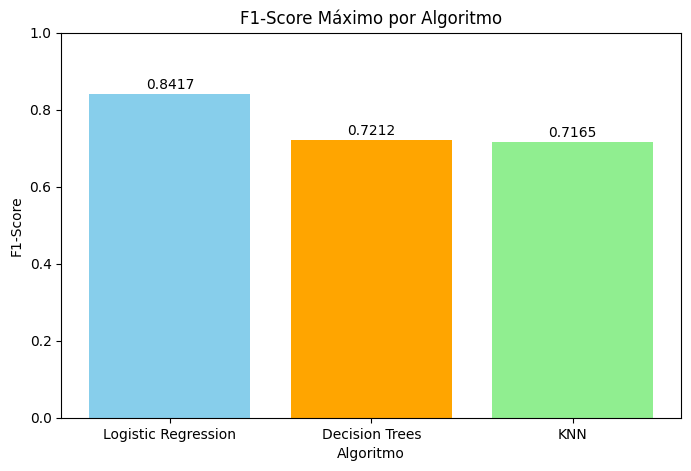

In [ ]:
diagrama_barras_f1_max(table)

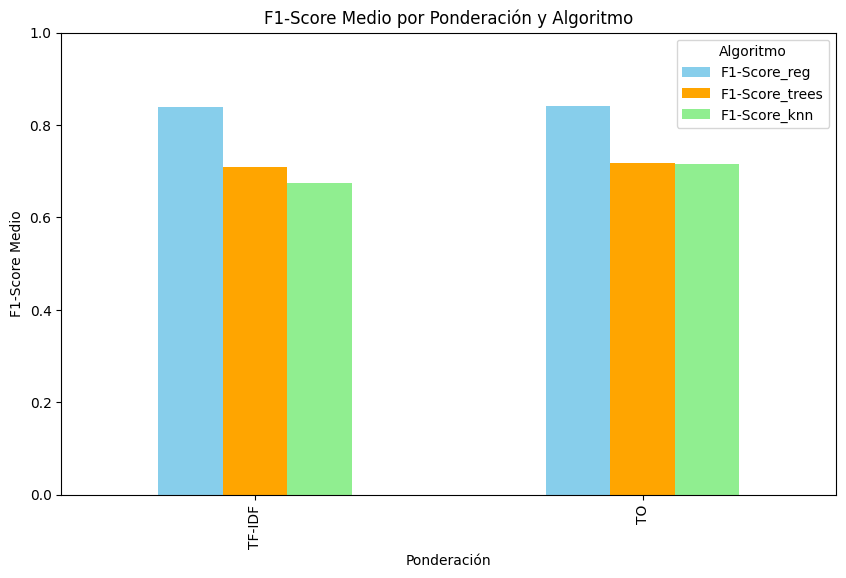

In [ ]:
diagrama_barras_f1_promedio_ponderacion(table)

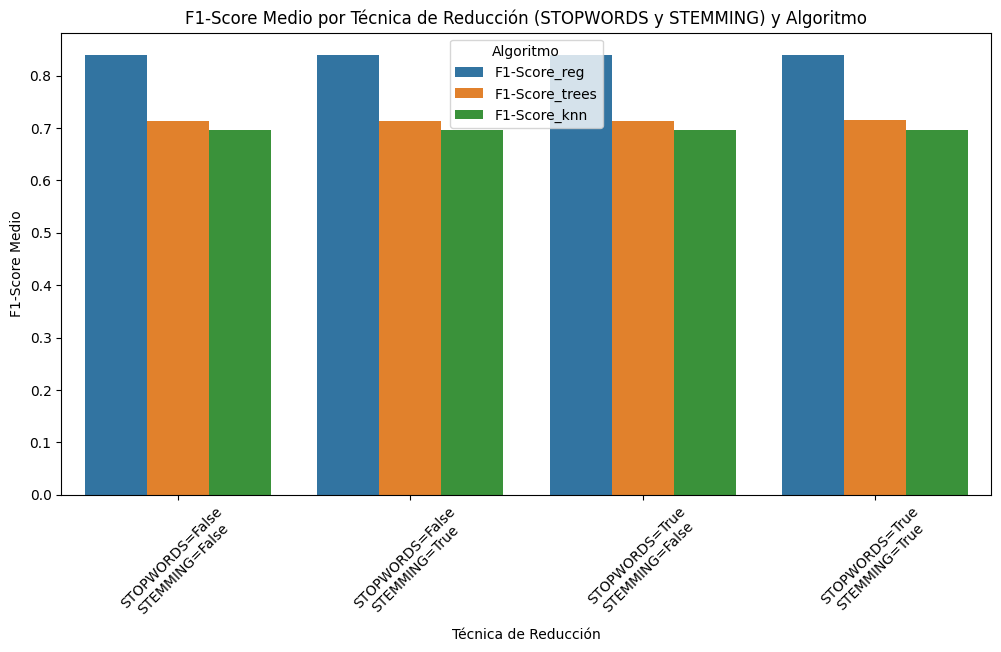

In [ ]:
diagrama_barras_f1_promedio_tecnica_reduccion(table)

#Conclusiones

- De las tres técnicas de aprendizaje implementadas, la que tuvo mejor rendimiento general fue la Regresión Logística con valores superiores a 80% para cada una de las 4 variaciones del corpus.

- En cuanto al F1-Score el máximo valor lo tuvo la regresión logística con un 84.17%. Seguido de este estuvieron los árboles de decisión con un 72.12% y, finalmente, con un resultado similar KNN con 71.65%. De esto, se puede decir que la regresión logística es la

- Por técnica de reducción, la regresión es la técnica que mejor se ajusta a los datos recolectados y que tanto precision como recall tienen valores similares en cada técnica de reducción en cuanto al valor de F1-Score

- La ponderación TO (frecuencia absoluta) fue aquella que presentó mejores resultados para las tres técnicas de aprendizaje. En el caso de la regresión logística, esta obtuvo valores muy similares de F1-Score con ambas ponderaciones y el mayor valor de las tres técnicas. En cuanto a los árboles de decisión y KNN, estos también obtuvieron valores similares en TO. Mientras que en TF-IDF los árboles de decisión presentaron un valor de F1-Score ligeramente mayor a KNN.
